In [1]:
!pip install yfinance

# 듀얼 모멘텀 전략을 본격적으로 실시하기에 앞서서
* 듀얼 모멘텀은 근 6개월 내 가장 퍼포먼스가 좋았던 자산들 위주로 포트폴리오를 구성하는 전략이다.
* 주식 뿐 아니라 다양한 자산군을 취급하며, 상승 추이가 보이는 자산 위주로 보유하고 하락 추세인 자산은 처분한다.
* 해당 노트북에서 우리는 근 3년간 S&P500의 각 섹터별 퍼포먼스를 관찰해보며 현재 섹터별 추이를 파악해 볼 것이다.


## 목표
* 수익률이 높은 섹터를 어떻게 선택하고 또한 포트폴리오의 MDD를 어떻게 낮출 것인가?
    * 각 섹터별 상관관계 분석
* 현재 추이가 지속된다고 단언 할 수 있는가? 현재 추이와 정반대인 금리 상승기에는 어떤 섹터가 상승했었는지 파악해보자.
    * 앞으로 금리 상승이 기대 되기에 이 또한 포트폴리오 구성에 활용할 수 있다.

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#### 섹터별 퍼포먼스는 각 섹터를 대표하는 SDPR ETF를 통해 추적한다.

In [3]:
sectors = ['Tech','Energy','Finance','Utility','Industrial','Health','Retail','Real Estate']
etfs = ['XLK','XLE','XLF','XLU','XLI','XLV','XRT','VNQ']
start_date = '2019-01-01'
price_table = pd.DataFrame(columns=sectors)
for s,e in zip(sectors,etfs):
    price_table[s] = yf.download(e,start_date)['Adj Close']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### 각 섹터 지수를 추종하는 ETF의 수정 종가 데이터 테이블 생성

In [4]:
price_table

,Tech,Energy,Finance,Utility,Industrial,Health,Retail,Real Estate
Date,,,,,,,,
2018-12-31,60.135616,49.342957,22.559935,48.790077,61.469170,82.517365,39.596001,68.180428
2019-01-02,60.174427,50.315201,22.749355,47.951096,61.784096,81.267815,40.156281,66.699242
2019-01-03,57.137569,49.816174,22.237921,47.941879,59.904045,79.617668,39.596001,67.165520
2019-01-04,59.669895,51.511127,22.976658,48.651787,62.175377,81.992737,40.813148,67.951843
2019-01-07,60.203529,52.276863,23.005074,48.319881,62.681183,82.307510,42.078598,68.619308
...,...,...,...,...,...,...,...,...
2021-07-19,148.229996,46.959999,35.110001,65.220001,99.779999,127.269997,91.459999,103.389999
2021-07-20,150.429993,47.590000,35.980000,65.500000,102.570000,128.820007,94.589996,105.830002
2021-07-21,151.880005,49.250000,36.599998,64.779999,103.550003,129.029999,96.330002,105.820000


In [5]:
start_end = price_table.iloc[[0,-1]]
start_end = np.around(start_end.pct_change()*100).iloc[1] #행의 모든 원소가 nan이여야 드랍
start_end

Tech           157.0
Energy          -2.0
Finance         61.0
Utility         35.0
Industrial      69.0
Health          59.0
Retail         143.0
Real Estate     55.0
Name: 2021-07-23 00:00:00, dtype: float64

### 2018/12/31과 비교 했을 때 테크는 150% 리테일은 140% 건설업은 68%의 상승을 보여줬다.
    * 유일하게 에너지 섹터만이 하락했다.

<BarContainer object of 8 artists>

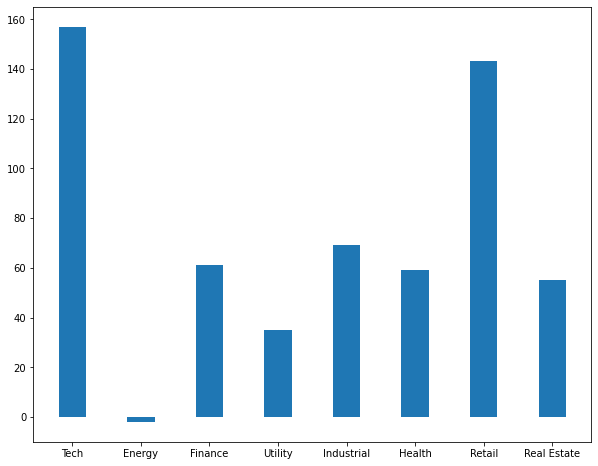

In [6]:
x = np.arange(len(sectors))
plt.figure(figsize = (10,8))
plt.bar(sectors,start_end,width = 0.4,align='center') #align은 막대를 라벨 어느 방향에 위치 시킬 것인지를 결정한다.

### 시작과 끝을 비교해봤을 떄 코로나로 인한 수혜를 가장 많이 받은 직종은 크게 테크와 소매 업종이었다.
    * 이제 지난 6개월 간의 추이와 지난 한달 간의 추이를 살펴보며 최근 동향을 파악해보자
    * 또한 이를 월 평균 수익률과 비교 해보며 상대적 부진 구간인지 구분해보자

### 월 평균 수익률은 현재 까지의 수익률에서 기하평균을 사용해 계산한다.
    * 월 별 수익률은 첫일 부터 말일에 이르기까지 해당 ETF를 보유하고 있을 때 얻은 수익으로 산출한다.
[파이썬에서 dateTime 다루기](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=hyozzi9&logNo=222102146435)

In [7]:
performance_per_month = price_table[price_table.index.day == 1] #인덱스에서 day 속성이 1인 요소만 가져온다.
performance_per_month

,Tech,Energy,Finance,Utility,Industrial,Health,Retail,Real Estate
Date,,,,,,,,
2019-02-01,64.686043,55.830250,24.671968,50.292866,68.598083,86.561684,42.349079,75.778358
2019-03-01,69.217087,57.172440,25.278112,52.671528,72.921265,88.660126,44.599842,76.555542
2019-04-01,73.013000,58.089096,25.073978,53.656590,73.504768,87.975464,43.893124,79.985168
2019-05-01,76.419846,56.181416,26.454285,53.972378,74.387817,85.304306,43.679955,79.966759
2019-07-01,77.441978,55.801678,26.723026,55.685841,74.701683,89.514206,41.330734,81.219246
2019-08-01,78.496941,53.622807,26.416855,56.322472,73.564148,87.745087,40.113979,82.641708
2019-10-01,78.173187,51.066723,26.359196,60.937534,73.430687,86.168915,41.172878,86.565163
2019-11-01,82.964691,52.347137,28.003639,60.465809,77.743301,91.594894,42.697800,88.355133
2020-04-01,75.636009,25.931854,19.056459,50.014458,55.307842,83.550301,27.701056,62.297558


In [8]:
percent_per_month = performance_per_month.pct_change()
percent_per_month.shape #dataFrame의 형태를 알아보기 위한 메서드 (행의 수 , 열의 수)


(20, 8)

### 분명 우리는 19년 1월 부터 21년 7월까지 30개월을 탐색했지만, 매달 1일의 데이터는 어쩐 일인지 20개 밖에 존재하지 않았다.
* 이는 1일에 주말이 있거나 공휴일이 있는 경우 이므로 이 경우를 생각해 매달 1일이 아닌 첫 거래일을 탐색해준다.

In [9]:
import datetime
months = np.arange(1,13) #12개월
years = np.arange(2019,2022) #시작년도와 종료년도
now = datetime.datetime.now()
first_open_day = [] #월 첫 개장일
for y in years:
    for m in months:
        month = price_table[(price_table.index.year == y) & (price_table.index.month == m)] #해당 년도의 해당 월 데이터 가져옴
        if not month.empty:
            first_open_day.append(month.iloc[0].name.strftime('%Y-%m-%d')) #날짜 데이터를 문자열로 변환해준다
    

In [43]:
start_date = first_open_day[0] #첫 개장일
end_date = price_table.index[-1]# 마지막 개장일
end_date

Timestamp('2021-07-23 00:00:00')

In [11]:
print(price_table.loc[first_open_day]) #매월 첫 개장일 데이터를 가져온다.

                  Tech     Energy    Finance    Utility  Industrial  \
Date                                                                  
2019-01-02   60.174427  50.315201  22.749355  47.951096   61.784096   
2019-02-01   64.686043  55.830250  24.671968  50.292866   68.598083   
2019-03-01   69.217087  57.172440  25.278112  52.671528   72.921265   
2019-04-01   73.013000  58.089096  25.073978  53.656590   73.504768   
2019-05-01   76.419846  56.181416  26.454285  53.972378   74.387817   
2019-06-03   68.749619  51.611629  24.921671  54.641113   69.627007   
2019-07-01   77.441978  55.801678  26.723026  55.685841   74.701683   
2019-08-01   78.496941  53.622807  26.416855  56.322472   73.564148   
2019-09-03   76.738678  50.052628  25.488770  59.627293   72.041000   
2019-10-01   78.173187  51.066723  26.359196  60.937534   73.430687   
2019-11-01   82.964691  52.347137  28.003639  60.465809   77.743301   
2019-12-02   85.149788  52.002750  28.811440  59.097809   78.198799   
2020-0

In [12]:
percent_per_month = price_table.loc[first_open_day].pct_change()
percent_per_month.shape[0]

31

### 무작정 1일의 데이터에 접근 할 때에 비해 훨씬 많은 데이터에 접근 할 수 있게 됐다.
* 20개에서 31개로 모든 월에 대한 장 초가를 알 수 있게 됐다

In [13]:
percent_per_month

,Tech,Energy,Finance,Utility,Industrial,Health,Retail,Real Estate
Date,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,0.074976,0.109610,0.084513,0.048837,0.110287,0.065141,0.054607,0.136120
2019-03-01,0.070047,0.024041,0.024568,0.047296,0.063022,0.024242,0.053148,0.010256
2019-04-01,0.054841,0.016033,-0.008076,0.018702,0.008002,-0.007722,-0.015846,0.044799
2019-05-01,0.046661,-0.032841,0.055049,0.005885,0.012013,-0.030363,-0.004857,-0.000230
2019-06-03,-0.100370,-0.081340,-0.057934,0.012390,-0.064000,-0.018070,-0.106034,0.002994
2019-07-01,0.126435,0.081184,0.072281,0.019120,0.072884,0.068662,0.058449,0.012631
2019-08-01,0.013623,-0.039047,-0.011457,0.011433,-0.015228,-0.019764,-0.029439,0.017514
2019-09-03,-0.022399,-0.066579,-0.035132,0.058677,-0.020705,-0.013040,-0.049745,0.047812


### 누적 수익률 계산
* 각 월별 누적 수익률을 계산해보자
* 산술 계산을 통한 수익률 도출은 정확하지 않을 수 있으므로 누적 수익률을 사용한다.
* 누적 수익률을 활용해 월 평균 수익률을 구해볼 수도 있다.

In [14]:
profit_per_month = (1 + percent_per_month).cumprod() - 1 #총 누적 수익률을 계산
profit_per_month

,Tech,Energy,Finance,Utility,Industrial,Health,Retail,Real Estate
Date,,,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-01,0.074976,0.109610,0.084513,0.048837,0.110287,0.065141,0.054607,0.136120
2019-03-01,0.150274,0.136286,0.111157,0.098443,0.180259,0.090962,0.110657,0.147772
2019-04-01,0.213356,0.154504,0.102184,0.118986,0.189704,0.082538,0.093058,0.199192
2019-05-01,0.269972,0.116589,0.162859,0.125571,0.203996,0.049669,0.087749,0.198916
2019-06-03,0.142506,0.025766,0.095489,0.139518,0.126941,0.030702,-0.027589,0.202505
2019-07-01,0.286958,0.109042,0.174672,0.161305,0.209076,0.101472,0.029247,0.217694
2019-08-01,0.304490,0.065738,0.161213,0.174582,0.190665,0.079703,-0.001053,0.239020
2019-09-03,0.275271,-0.005219,0.120417,0.243502,0.166012,0.065624,-0.050746,0.298260


### 누적 수익률을 계산해 총 수익률을 확인해보자
* xticks나 yticks등을 통해 label의 간격 등을 설정 할 수 있다
* [xtick,ytick 설정법](https://wikidocs.net/92089)

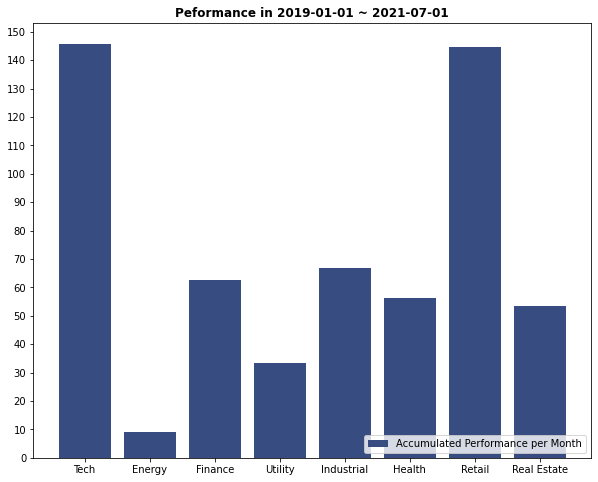

In [15]:
plt.figure(figsize = (10,8))
# x = np.arange(len(sectors))
# plt.bar(x - width/2,start_end,width,align='center',color = '#374c80') #align은 막대를 라벨 어느 방향에 위치 시킬 것인지를 결정한다.
plt.bar(sectors,profit_per_month.iloc[-1]*100,color = '#374c80') #align은 막대를 라벨 어느 방향에 위치 시킬 것인지를 결정한다.
# plt.xticks(x,sectors)
plt.yticks(np.arange(0,160,10)) #yticks나 xticks를 통해 라벨을 어떻게 표시할지 설정할 수 있다
plt.title("Peformance in 2019-01-01 ~ 2021-07-01",fontweight = 'bold')
plt.legend(["Accumulated Performance per Month"],loc = 'lower right') #simple은 시작날짜의 가격과 종료 날짜의 가격을 비교하는 방법이다

### 앞서 간략히 살펴봤던 수익률과 마찬가지로 누적 수익률로도 기술 섹터와 소매 섹터가 압권이었다.
* 간략히 계산해본 수익률에서 테크는 156% 소매는 142%의 수익률이 확인됐다. (7월 23일 까지의 데이터)
* 반면 누적 곱을 통한 수익률에서 테크는 145% 소매는 144%의 수익률을 확인 할 수 있었다. (7월 1일 까지의 데이터)
* 7월달도 테크 섹터의 달이 였다는 것을 짐작할 수 있다.

In [52]:
from dateutil.relativedelta import relativedelta #timedelta는 시간,일,주만 활용가능하기 때문에 relative delta로 사용해줘야한다
def get_last_month_table(count_month_before): #n월 전의 고점 데이터를 반환함
        before_month = (end_date - relativedelta(months=count_month_before)) #가장 최근에 위치한 달로 부터 측정하고 싶은 달과 가장 가까운 날짜 반환
        # while check_point_day not in price_table.index: #개장일이여야 하므로
        #         check_point_day -= relativedelta(days=1)
        before_month_high = price_table.loc[(price_table.index.year == before_month.year) & (price_table.index.month == before_month.month)].max()
        return before_month_high
six_month_price = get_last_month_table(6)
last_month_price = get_last_month_table(1)
six_month_profit = (price_table.loc[end_date.strftime('%Y-%m-%d')] - six_month_price) / six_month_price  #최근 6개월 수익률
last_month_profit = (price_table.loc[end_date.strftime('%Y-%m-%d')] - last_month_price) / last_month_price #최근 한달 간의 수익률
avg_profit_per_month = percent_per_month.mean(axis='index') #월 평균 수익률



In [53]:
print(six_month_profit)
print(last_month_profit)
print(avg_profit_per_month)

Tech           0.158180
Energy         0.113668
Finance        0.162269
Utility        0.040793
Industrial     0.152399
Health         0.117732
Retail         0.056705
Real Estate    0.232064
dtype: float64
Tech           0.045325
Energy        -0.127676
Finance       -0.053714
Utility       -0.003456
Industrial    -0.015089
Health         0.043244
Retail        -0.014661
Real Estate    0.010457
dtype: float64
Tech           0.032915
Energy         0.011579
Finance        0.019860
Utility        0.011225
Industrial     0.019886
Health         0.016098
Retail         0.036439
Real Estate    0.016923
dtype: float64


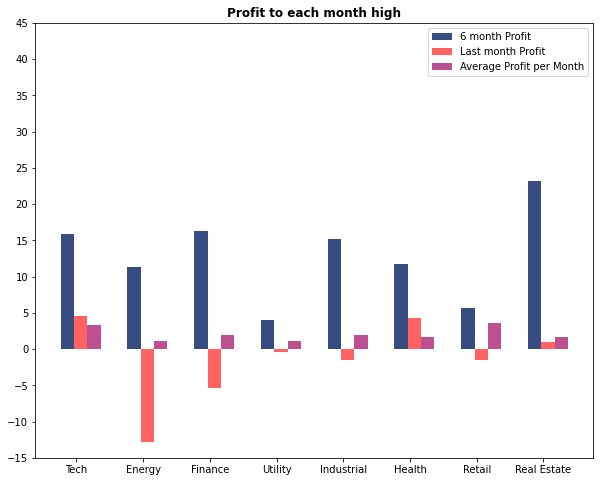

In [57]:
plt.figure(figsize = (10,8))
x = np.arange(len(sectors))
width = 0.2
plt.bar(x - width*2/3,six_month_profit*100,width,align='center',color = '#374c80') #align은 막대를 라벨 어느 방향에 위치 시킬 것인지를 결정한다.
plt.bar(x + width/3,last_month_profit*100,width,color = '#ff6361') #align은 막대를 라벨 어느 방향에 위치 시킬 것인지를 결정한다.
plt.bar(x + width*4/3,avg_profit_per_month*100,width,color = '#bc5090') #align은 막대를 라벨 어느 방향에 위치 시킬 것인지를 결정한다.
plt.xticks(x,sectors)
plt.yticks(np.arange(-15,50,5))
#yticks나 xticks를 통해 라벨을 어떻게 표시할지 설정할 수 있다
plt.title("Profit to each month high",fontweight = 'bold')
plt.legend(["6 month Profit","Last month Profit","Average Profit per Month"],loc = 'upper right') #simple은 시작날짜의 가격과 종료 날짜의 가격을 비교하는 방법이다

### 수익률 분석
* 전체 수익률은 기술과 소매 섹터가 압도적 1위이다.
* 지난 6개월 동안은 부동산,건설,금융,테크 등의 섹터가 빛을 발했다.
    * 이는 지난 6개월 간 **금리 상승에 대한 시그널이** 계속 보였던 것도 한 몫을 하는 듯하다.
* **테크**는 전체 수익률 1위이고 6개월 수익률도 준수하며 최근까지도 준수한 퍼포먼스를 보여주고 있다.
* 지난달 금융 및 에너지가 크게 하락하며 <u>경기순환주로 쏠리던 유동성이 다시금 되돌아가는 모습</u>이 보이고 있다.

### 앞으로도 테크가 정답일까?
* 테크 섹터는 코로나의 대표적 수혜주로 코로나 기간인 2년 내내 꾸준한 사랑을 받고있다.
* 사랑을 향한 보답이라도 하듯 테크 기업들은 연이은 어닝 서프라이즈와 주가 상승을 선보이고 있다.
* 지난 2년 6개월, 1년, 전 달의 수익률 비교를 해봐도 테크만큼 준수한 섹터가 나타나지 않는 것으로 보인다.
* 과연 테크는 정말 앞으로도 투자하기 적합하며 단점이란 없는 섹터일까??

### 각 섹터별 MDD 분석
* 각 섹터별 MDD를 분석해 수익률이 아닌 다른 지표로 섹터를 비교해보자
* MDD는 총 2019.01 ~ 2021.07.23 동안 연 단위 간격으로 측정한다.

In [63]:
#우선 가격 데이터가 담긴 테이블을 불러오자
price_years = []
for i in range(2019,2022):
    price_years.append(price_table[price_table.index.year == i])
mdd_years = []
for y in price_years:
    # print(y.max(),"  ",y.min())
    mdd_years.append((y.max() - y.min()) / y.max())

print(mdd_years)

[Tech           0.367685
Energy         0.178549
Finance        0.254220
Utility        0.219721
Industrial     0.250923
Health         0.203524
Retail         0.189532
Real Estate    0.252788
dtype: float64, Tech           0.464537
Energy         0.606046
Finance        0.428625
Utility        0.360668
Industrial     0.460497
Health         0.350255
Retail         0.588959
Real Estate    0.423982
dtype: float64, Tech           0.189401
Energy         0.331527
Finance        0.250786
Utility        0.144603
Industrial     0.199186
Health         0.163465
Retail         0.354790
Real Estate    0.236337
dtype: float64]


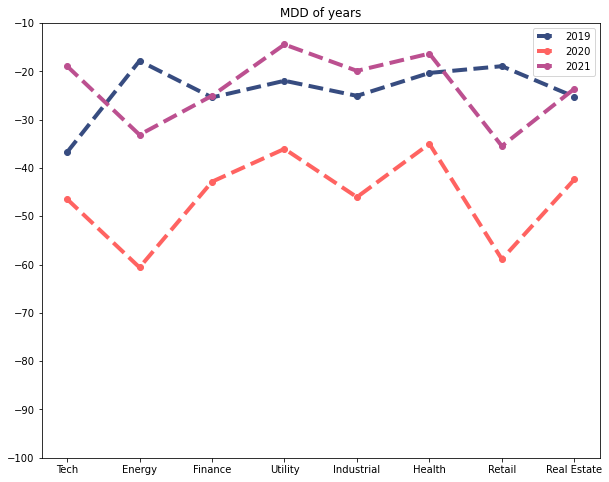

In [72]:
plt.figure(figsize = (10,8))
plt.title("MDD of years")
colors = ['#374c80','#ff6361','#bc5090']
for color,y in zip(colors,mdd_years):
    plt.plot(y*-100,lw = 4,ls='--',marker="o",c=color)
plt.yticks(np.arange(-100,0,10))
plt.legend(['2019','2020','2021'],loc='upper right')

### MDD 해석
* 헬스케어와 유틸리티 섹터가 낙폭이 제일 적었고 건설,에너지,소매 쪽의 최대 낙폭이 가장컸다.
* 테크는 2019년엔 낙폭이 큰 편이지만, 20,21에 들어서선 MDD가 큰 폭으로 감소했다.
* 사실 이 MDD 측정 방식은 문제가 있다. 1년 중 최대 낙폭만을 표현하기 때문이다. 최대 낙폭은 적더라도 작은 낙폭이 자주 존재한다면, 투자에 적합치 않다.
* 시계열을 활용해 MDD를 측정해 낙폭이 얼마나 발생했는지 정확히 측정해보자